In [2]:
import glob
import pandas as pd
import mne
import matplotlib
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.io import loadmat

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# V1

In [9]:
df[['name', 'sub', 'exp']].groupby('sub').first()

,name,exp
sub,,
sub02,David Brown,exp01
sub03,Sarah Brunet,exp03
sub04,Lynette Gallaty,exp02
sub05,Mana Higashihara,exp02
sub06,Tim Howells,exp01
sub07,Merolene Pirsarkiewicz,exp01
sub08,Steve Vucic,exp03
sub10,Nimeshan Geevasinga,exp02
sub12,Marshall Owen,exp03


(2863, 28)


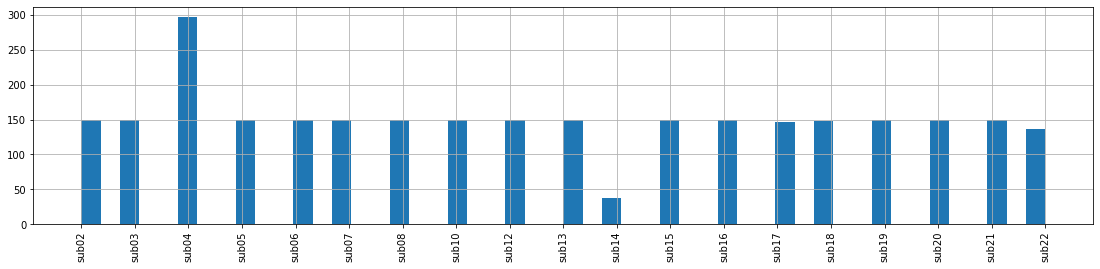

In [10]:
# df = pd.read_excel('139-new-ld-v3.xlsx')
df = pd.read_excel('148-csd-avg-v1.xlsx')
df['sub'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')
print(df.shape)

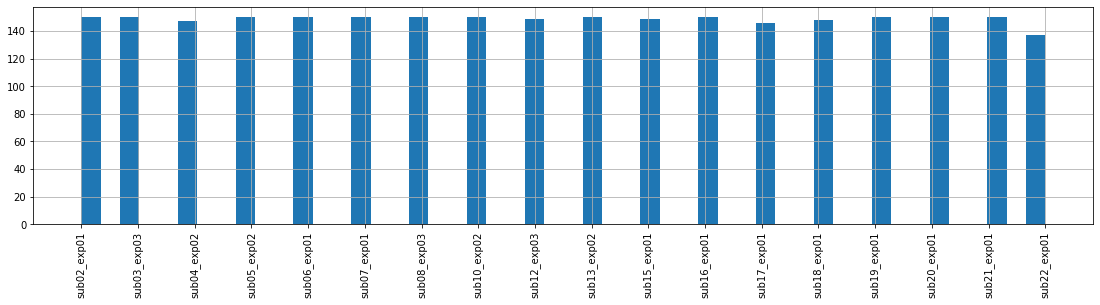

In [11]:
# df = df[~df['sub'].isin(['sub05', 'sub09', 'sub11', 'sub10'])]
# df = df[~df['sub'].isin(['sub05', 'sub09', 'sub11', 'sub10', 'sub03', 'sub06', 'sub12'])]
df['sub_exp'] = df['sub'] + "_" + df['exp']
df['sub_exp_run'] = df['sub_exp'] + "_" + df['run']
df = df[~df['sub_exp'].isin(['sub04_exp01', 'sub14_exp01'])]
# df = df[~df['sub_exp'].isin(['sub03_exp01'])]
# df = df[df['mep_latency'] < 0.2]
# df = df[df['mep_latency'] > 0]
# df.to_excel('140-ld-v3.xlsx')
df.to_excel('148-csd-avg-v2.xlsx')
df['sub_exp'].hist(figsize=(19,4), xrot=90, bins=50, align='mid')

# V2

In [161]:
df['theta_power_log'] = np.log(df['theta_power'])
df['mu_power_log'] = np.log(df['mu_power'])
df['beta_power_log'] = np.log(df['beta_power'])
df['gamma_power_log'] = np.log(df['gamma_power'])
df['mep_size_log'] = np.log(df['mep_size'])
df['mep_duration_log'] = np.log(df['mep_duration'])
df['mep_area_log'] = np.log(df['mep_area'])
df.shape

(2713, 37)

In [50]:
def plot_interaction(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    sns.regplot(x='theta_power_log', y=y_var, data=df[(df['theta_phase'] >= 45) & (df['theta_phase'] <= 135)], ax=ax1, marker='.')
    sns.regplot(x='theta_power_log', y=y_var, data=df[(df['theta_phase'] >= 225) & (df['theta_phase'] <= 315)], ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    sns.regplot(x='mu_power_log', y=y_var, data=df[(df['mu_phase'] >= 45) & (df['mu_phase'] <= 135)], ax=ax2, marker='.')
    sns.regplot(x='mu_power_log', y=y_var, data=df[(df['mu_phase'] >= 225) & (df['mu_phase'] <= 315)], ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    sns.regplot(x='beta_power_log', y=y_var, data=df[(df['beta_phase'] >= 45) & (df['beta_phase'] <= 135)], ax=ax3, marker='.')
    sns.regplot(x='beta_power_log', y=y_var, data=df[(df['beta_phase'] >= 225) & (df['beta_phase'] <= 315)], ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    sns.regplot(x='gamma_power_log', y=y_var, data=df[(df['gamma_phase'] >= 45) & (df['gamma_phase'] <= 135)], ax=ax4, marker='.')
    sns.regplot(x='gamma_power_log', y=y_var, data=df[(df['gamma_phase'] >= 225) & (df['gamma_phase'] <= 315)], ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_all_bands(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='theta_power_log', y=y_var, data=x, ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='mu_power_log', y=y_var, data=x, ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='beta_power_log', y=y_var, data=x, ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    for sub in df['sub'].unique():
        x = df[df['sub'] == sub]
        sns.regplot(x='gamma_power_log', y=y_var, data=x, ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_reg(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    sns.regplot(x='theta_power_log', y=y_var, data=df, ax=ax1, marker='.')
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    sns.regplot(x='mu_power_log', y=y_var, data=df, ax=ax2, marker='.')
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    sns.regplot(x='beta_power_log', y=y_var, data=df, ax=ax3, marker='.')
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    sns.regplot(x='gamma_power_log', y=y_var, data=df, ax=ax4, marker='.')
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_mean(y_var, y_label):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    sns.lineplot(x='theta_power_log', y=y_var, data=df, ax=ax1)
    ax1.set_xlabel('Theta Power')
    ax1.set_ylabel(y_label)
    
    sns.lineplot(x='mu_power_log', y=y_var, data=df, ax=ax2)
    ax2.set_xlabel('Mu Power')
    ax2.set_ylabel(y_label)
    
    sns.lineplot(x='beta_power_log', y=y_var, data=df, ax=ax3)
    ax3.set_xlabel('Beta Power')
    ax3.set_ylabel(y_label)
    
    sns.lineplot(x='gamma_power_log', y=y_var, data=df, ax=ax4)
    ax4.set_xlabel('Gamma Power')
    ax4.set_ylabel(y_label)
    
def plot_phase(band):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    ax1.plot(df[band+'_phase'] * 0.0174533 - 3.1416, df['mep_size_log'], '.')
    ax1.set_xlabel(band + ' phase')
    ax1.set_ylabel('MEP Size (log)')
    
    ax2.plot(df[band+'_phase'] * 0.0174533 - 3.1416, df['mep_latency'], '.')
    ax2.set_xlabel(band + ' phase')
    ax2.set_ylabel('MEP Latency')
    
    ax3.plot(df[band+'_phase'] * 0.0174533 - 3.1416, df['mep_duration_log'], '.')
    ax3.set_xlabel(band + ' phase')
    ax3.set_ylabel('MEP Duration (log)')
    
    ax4.plot(df[band+'_phase'] * 0.0174533 - 3.1416, df['mep_area_log'], '.')
    ax4.set_xlabel(band + ' phase')
    ax4.set_ylabel('MEP Area (log)')

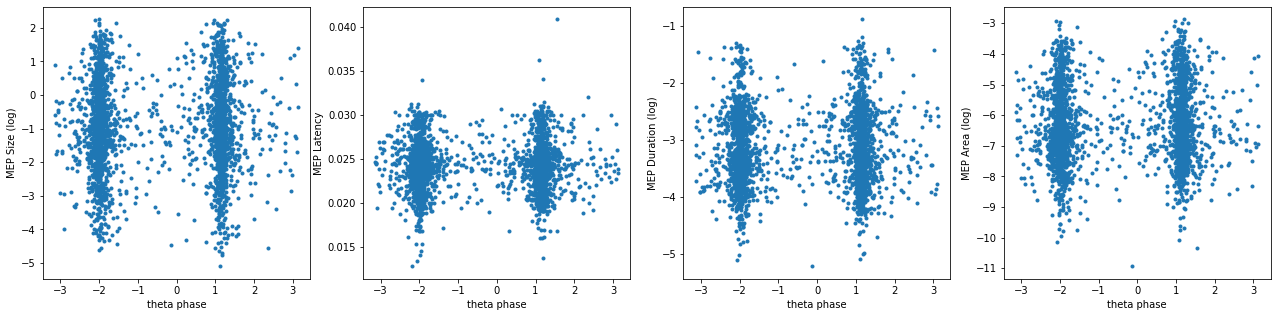

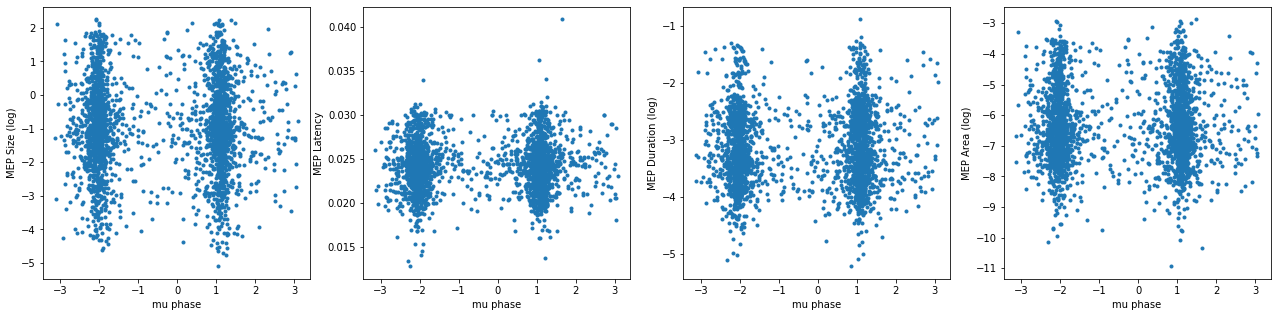

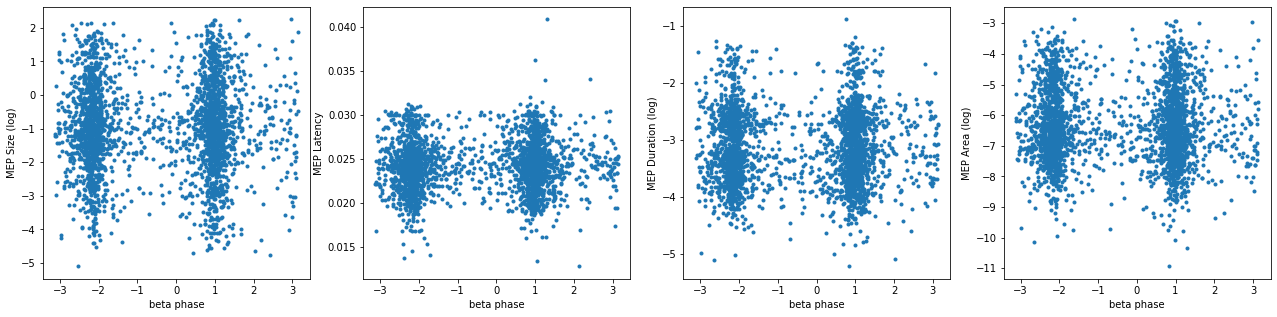

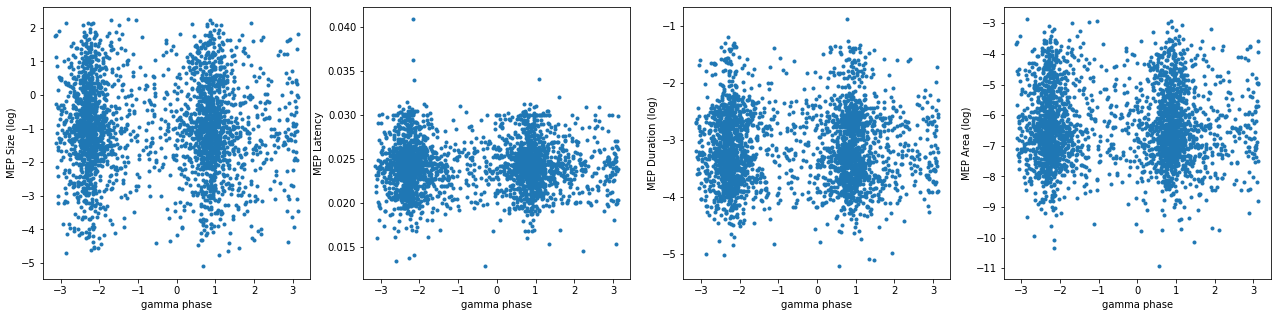

In [6]:
plot_phase('theta')
plot_phase('mu')
plot_phase('beta')
plot_phase('gamma')

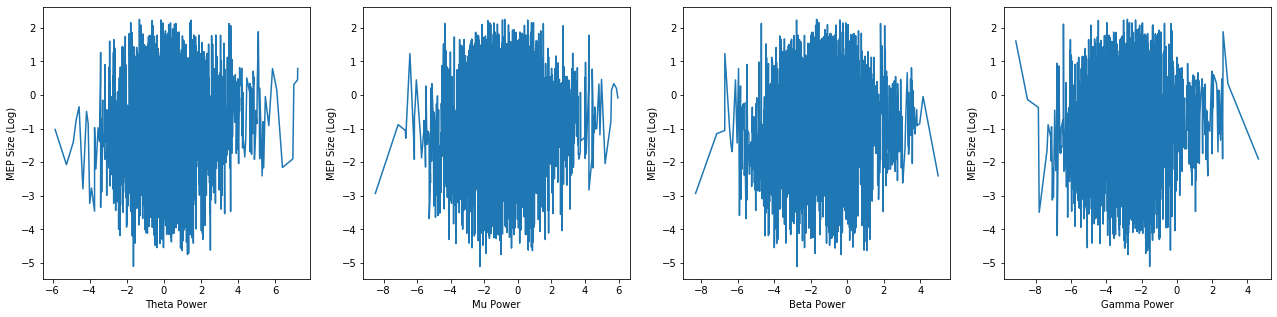

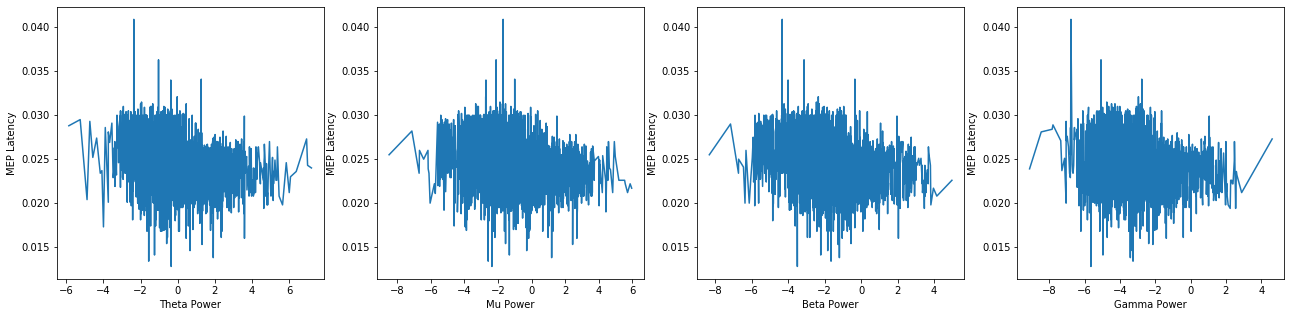

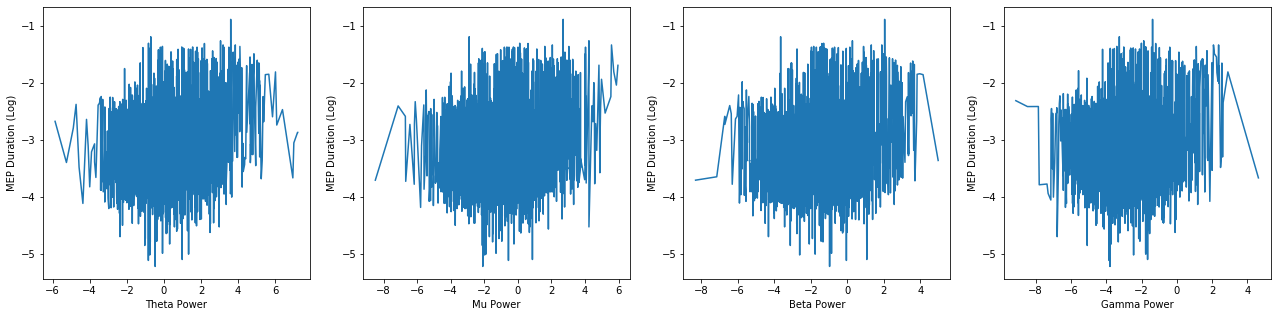

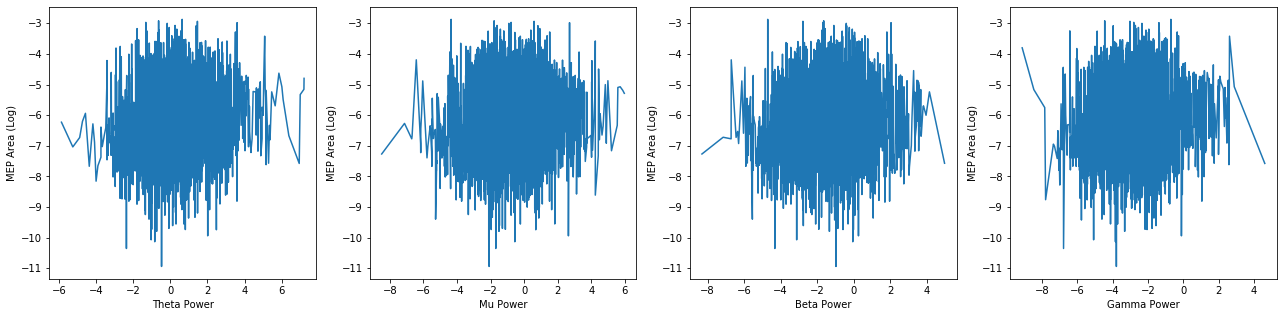

In [51]:
plot_mean('mep_size_log', 'MEP Size (Log)')
plot_mean('mep_latency', 'MEP Latency')
plot_mean('mep_duration_log', 'MEP Duration (Log)')
plot_mean('mep_area_log', 'MEP Area (Log)')

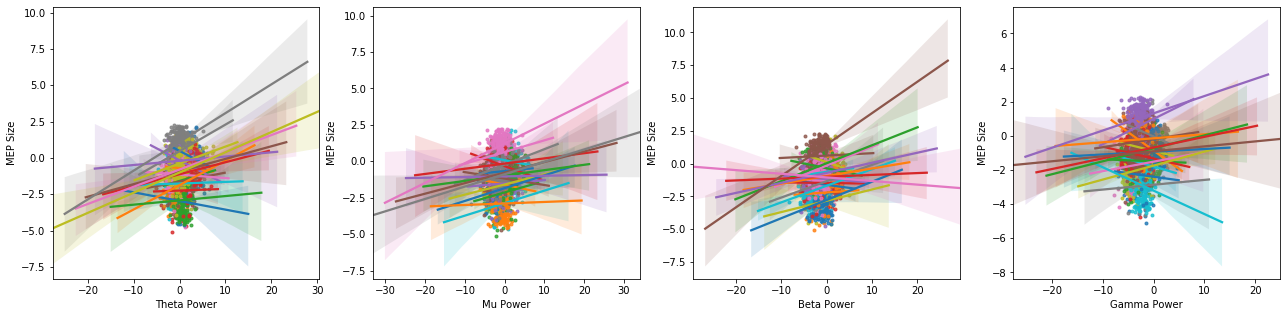

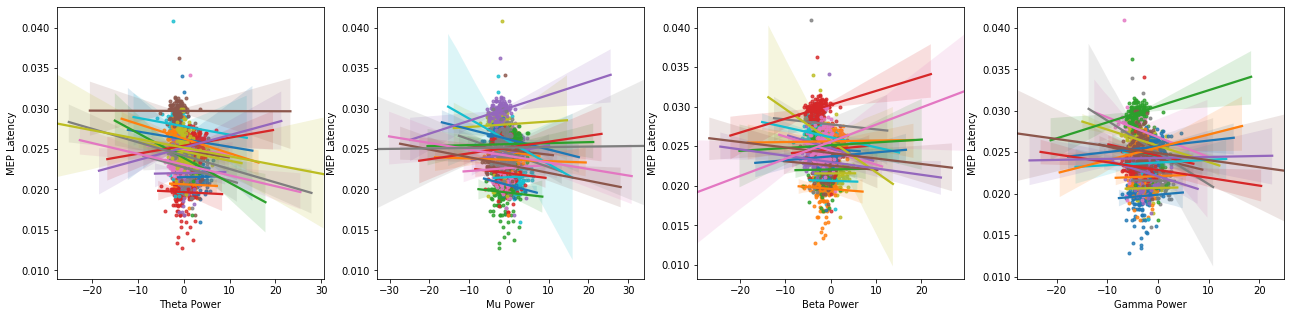

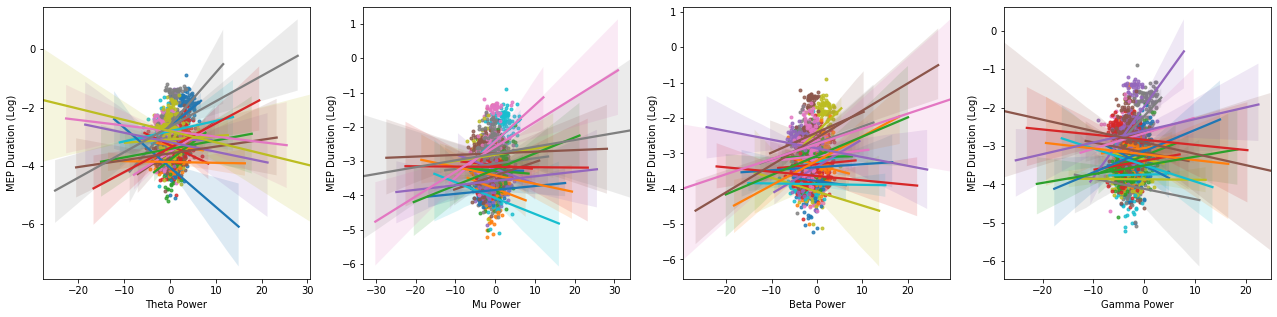

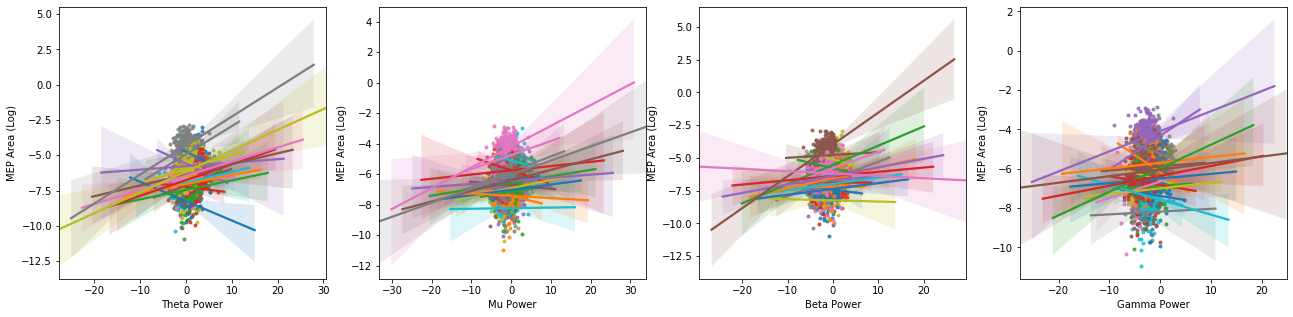

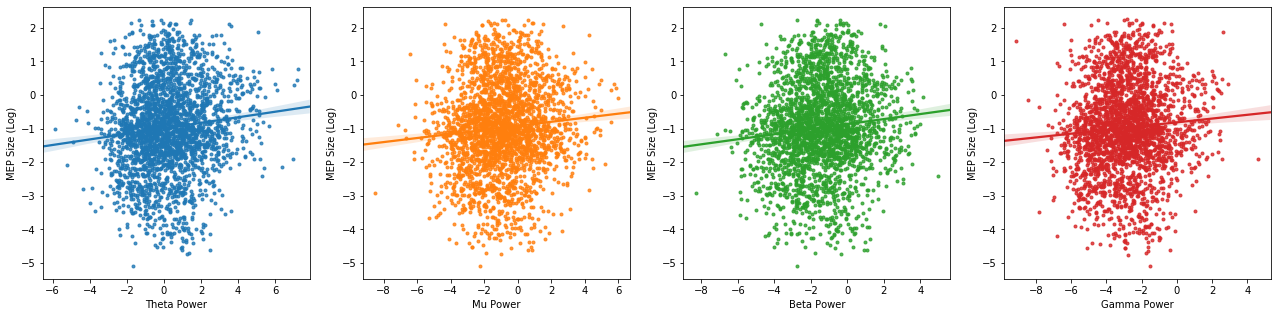

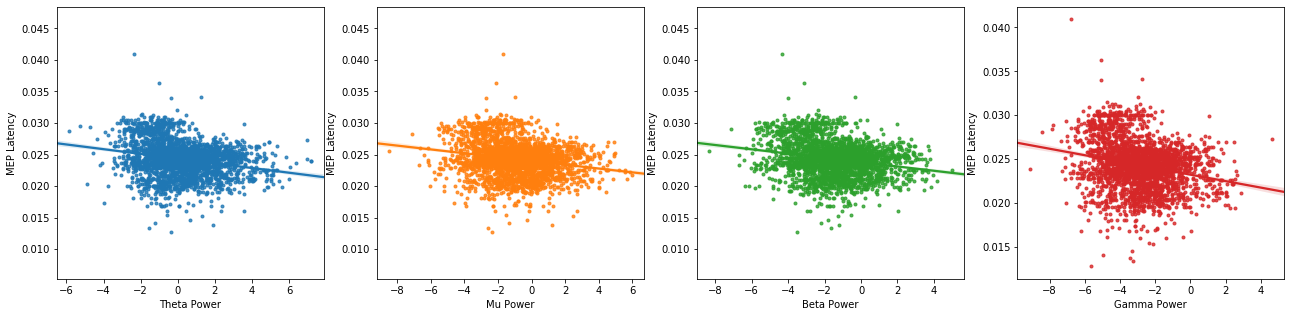

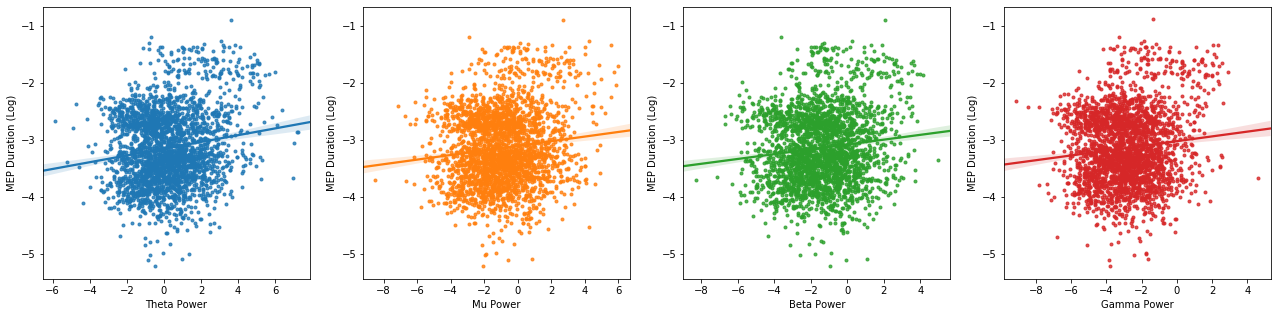

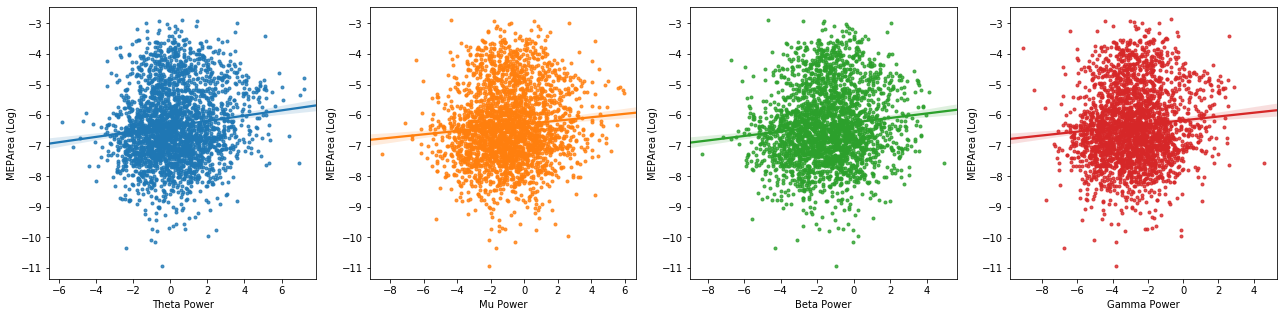

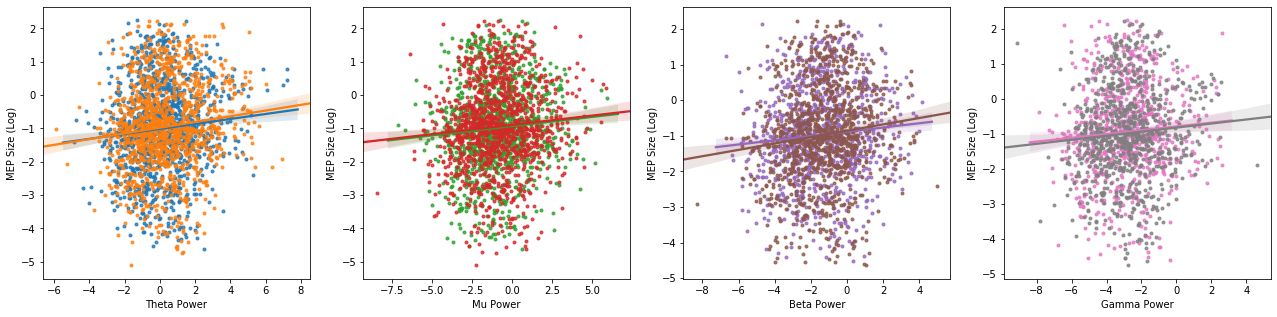

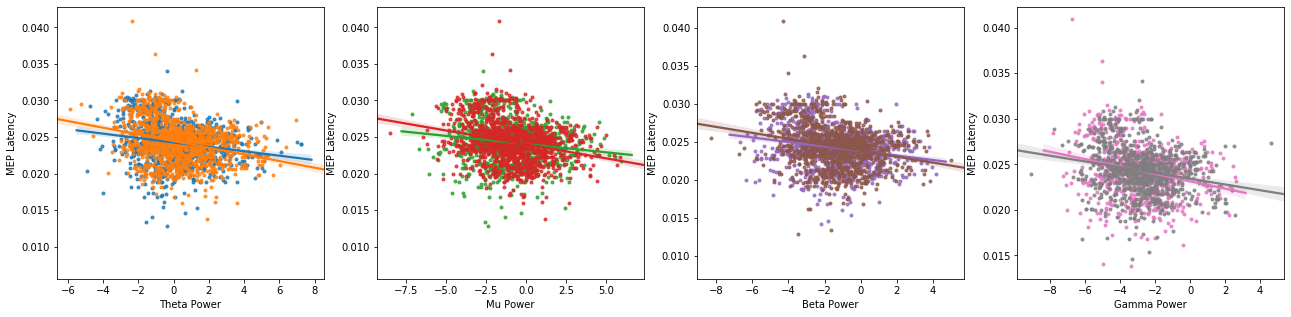

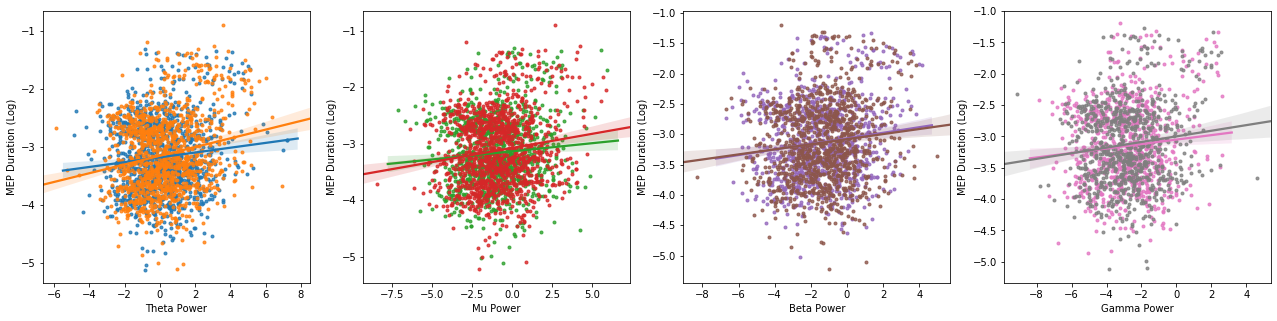

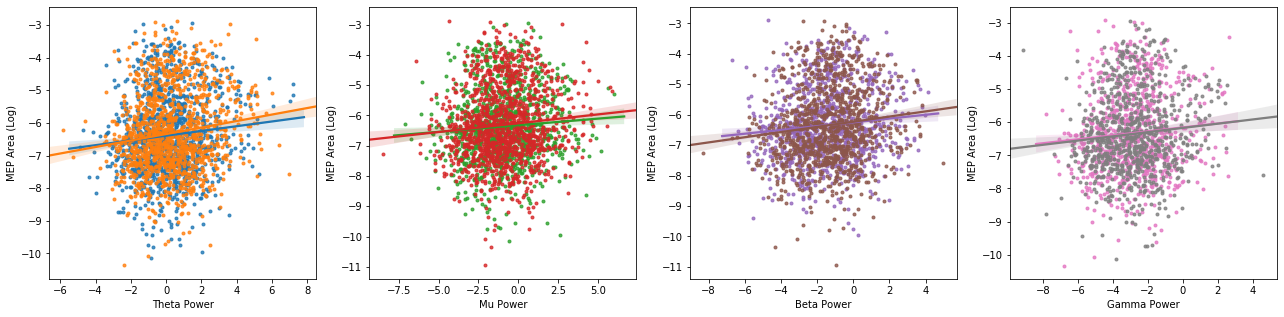

In [7]:
plot_all_bands('mep_size_log', 'MEP Size')
plot_all_bands('mep_latency', 'MEP Latency')
plot_all_bands('mep_duration_log', 'MEP Duration (Log)')
plot_all_bands('mep_area_log', 'MEP Area (Log)')

plot_reg('mep_size_log', 'MEP Size (Log)')
plot_reg('mep_latency', 'MEP Latency')
plot_reg('mep_duration_log', 'MEP Duration (Log)')
plot_reg('mep_area_log', 'MEPArea (Log)')

plot_interaction('mep_size_log', 'MEP Size (Log)')
plot_interaction('mep_latency', 'MEP Latency')
plot_interaction('mep_duration_log', 'MEP Duration (Log)')
plot_interaction('mep_area_log', 'MEP Area (Log)')

Text(0, 0.5, 'MEP Latency')

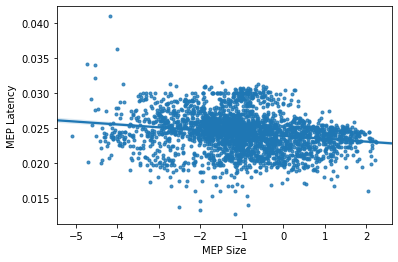

In [8]:
# plt.plot(np.log(df['mep_size']), df['mep_latency'], '.')
sns.regplot(x='mep_size_log', y='mep_latency', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Latency')

Text(0, 0.5, 'MEP Duration')

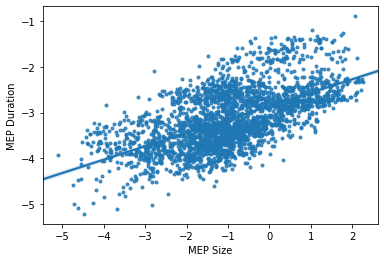

In [9]:
sns.regplot(x='mep_size_log', y='mep_duration_log', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Duration')

Text(0, 0.5, 'MEP Area')

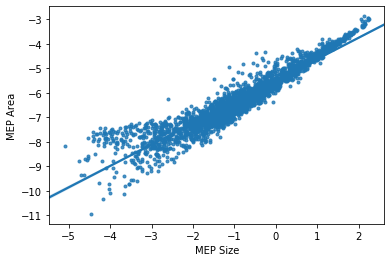

In [10]:
sns.regplot(x='mep_size_log', y='mep_area_log', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Area')

Text(0, 0.5, 'MEP Duration')

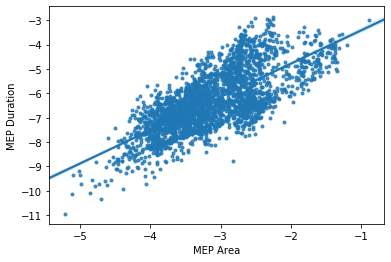

In [11]:
sns.regplot(x='mep_duration_log', y='mep_area_log', data=df, marker='.')
plt.xlabel('MEP Area')
plt.ylabel('MEP Duration')

Text(0, 0.5, 'MEP Duration')

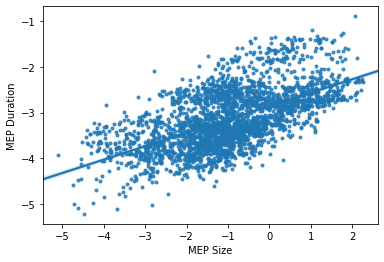

In [12]:
sns.regplot(x='mep_size_log', y='mep_duration_log', data=df, marker='.')
plt.xlabel('MEP Size')
plt.ylabel('MEP Duration')

In [6]:
df.to_excel('140-ld-v2.xlsx')

In [7]:
df['sub'].unique().shape

(19,)

# Figures for paper

Text(0, 0.5, 'Log transformed MEP size')

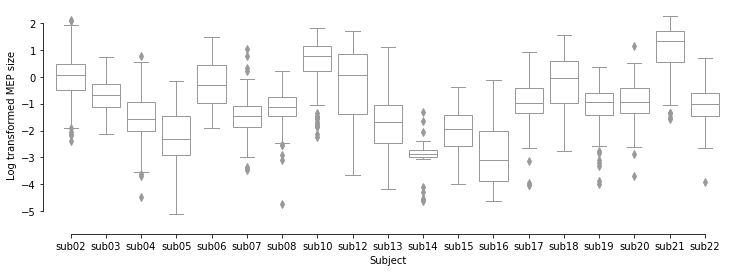

In [46]:
df_long = pd.melt(df, "sub", value_vars=['mep_size_log', 'mep_latency', 'mep_duration_log', 'mep_area_log'], var_name='mep', value_name='power')
df_long.head()
plt.figure(figsize=(12,4))
sns.boxplot(x="sub", y="mep_size_log", data=df, palette=[[1, 1, 1]], linewidth=1, color=[[0,0,0]])
sns.despine(offset=10, trim=True)
plt.xlabel('Subject')
plt.ylabel('Log transformed MEP size')

In [8]:
df_long = pd.melt(df, "sub", value_vars=['theta_power_log', 'mu_power_log', 'beta_power_log', 'gamma_power_log'], var_name='band', value_name='power')
df_long.head()

,sub,band,power
0,sub02,theta_power_log,6.011299
1,sub02,theta_power_log,5.463617
2,sub02,theta_power_log,5.135463
3,sub02,theta_power_log,4.771527
4,sub02,theta_power_log,3.960605


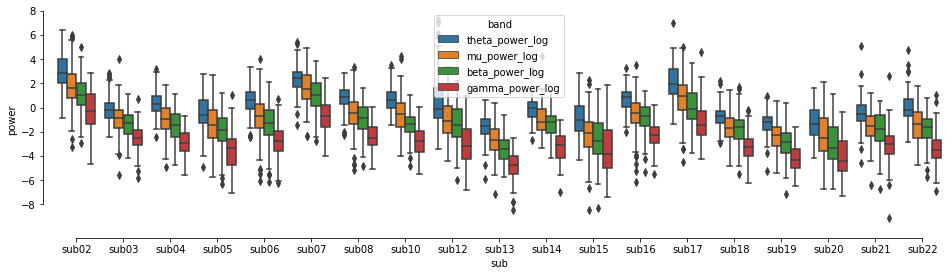

In [11]:
plt.figure(figsize=(16,4))
sns.boxplot(x="sub", y="power",
            hue="band",
            data=df_long)
sns.despine(offset=10, trim=True)

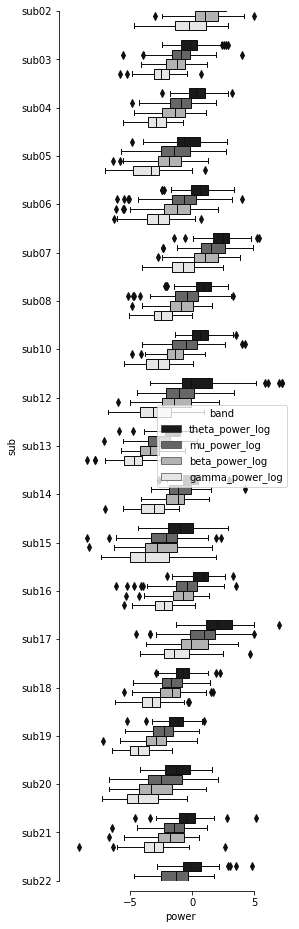

In [12]:
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
        [0.984375, 0.7265625, 0], # dark yellow
        [1, 1, 0.9]               # light yellow
    ])
    

plt.figure(figsize=(4,16))
sns.boxplot(x="power", y="sub", hue="band", data=df_long, orient='h', palette=get_colors(), linewidth=1)
sns.despine(offset=10, trim=True)

In [20]:
len(sub_dummy)

18

In [34]:
sub_dummy = ['sub01', 'sub02', 'sub03', 'sub04', 'sub05', 'sub06', 'sub07', 'sub08', 'sub09', 'sub10', 'sub11', 'sub12', 'sub13', 'sub14', 'sub15', 'sub16', 'sub17', 'sub18', 'sub19']
i = 0
df_mean = []
for sub in df['sub'].unique():
    df_mean.append({
        'sub': sub_dummy[i],
        'theta_mean': round(df[df['sub'] == sub]['theta_power_log'].mean(), 2),
        'theta_std': round(df[df['sub'] == sub]['theta_power_log'].std(), 2),
        'mu_mean': round(df[df['sub'] == sub]['mu_power_log'].mean(), 2),
        'mu_std': round(df[df['sub'] == sub]['mu_power_log'].std(), 2),
        'beta_mean': round(df[df['sub'] == sub]['beta_power_log'].mean(), 2),
        'beta_std': round(df[df['sub'] == sub]['beta_power_log'].std(), 2),
        'gamma_mean': round(df[df['sub'] == sub]['gamma_power_log'].mean(), 2),
        'gamma_std': round(df[df['sub'] == sub]['gamma_power_log'].std(), 2),
        'mep_size_log_mean': round(df[df['sub'] == sub]['mep_size_log'].mean(), 2),
        'mep_size_log_std': round(df[df['sub'] == sub]['mep_size_log'].std(), 2),
        'mep_latency_mean': round(df[df['sub'] == sub]['mep_latency'].mean(), 3),
        'mep_latency_std': round(df[df['sub'] == sub]['mep_latency'].std(), 3),
        'mep_duration_log_mean': round(df[df['sub'] == sub]['mep_duration_log'].mean(), 2),
        'mep_duration_log_std': round(df[df['sub'] == sub]['mep_duration_log'].std(), 2),
        'mep_area_log_mean': round(df[df['sub'] == sub]['mep_area_log'].mean(), 2),
        'mep_area_log_std': round(df[df['sub'] == sub]['mep_area_log'].std(), 2),
    })
    i = i+1
df_mean = pd.DataFrame(df_mean)
df_mean[['sub', 'theta_mean', 'theta_std', 'mu_mean', 'mu_std', 'beta_mean', 'beta_std', 'gamma_mean', 'gamma_std', 'mep_size_log_mean', 'mep_size_log_std', 'mep_latency_mean', 'mep_latency_std', 'mep_duration_log_mean', 'mep_duration_log_std', 'mep_area_log_mean', 'mep_area_log_std']]

,sub,theta_mean,theta_std,mu_mean,mu_std,beta_mean,beta_std,gamma_mean,gamma_std,mep_size_log_mean,mep_size_log_std,mep_latency_mean,mep_latency_std,mep_duration_log_mean,mep_duration_log_std,mep_area_log_mean,mep_area_log_std
0,sub01,2.98,1.41,1.66,1.72,1.10,1.46,-0.23,1.59,-0.02,0.88,0.022,0.001,-2.26,0.70,-5.22,0.89
1,sub02,-0.24,1.08,-0.91,1.28,-1.34,1.12,-2.54,1.03,-0.70,0.62,0.021,0.001,-3.28,0.47,-6.39,0.76
2,sub03,0.36,0.95,-0.94,1.27,-1.53,1.21,-2.91,1.04,-1.55,0.92,0.025,0.001,-3.76,0.47,-7.35,1.09
3,sub04,-0.39,1.35,-1.46,1.61,-1.89,1.43,-3.55,1.42,-2.25,1.00,0.020,0.002,-3.26,0.54,-7.23,0.79
4,sub05,0.57,1.11,-0.72,1.75,-1.31,1.49,-2.84,1.36,-0.26,0.86,0.022,0.001,-3.10,0.42,-5.68,0.79
5,sub06,2.32,1.05,1.57,1.46,1.02,1.36,-0.78,1.30,-1.49,0.71,0.025,0.002,-3.29,0.55,-6.88,0.75
6,sub07,0.81,1.04,-0.50,1.52,-0.94,1.22,-2.43,1.09,-1.17,0.66,0.025,0.001,-3.44,0.37,-6.72,0.62
7,sub08,0.62,0.97,-0.62,1.42,-1.48,1.06,-2.82,1.18,0.58,0.87,0.023,0.001,-2.49,0.72,-4.81,0.89
8,sub09,0.42,2.01,-0.99,1.62,-1.27,1.66,-3.04,1.64,-0.34,1.41,0.025,0.001,-3.09,0.68,-5.94,1.52
9,sub10,-1.55,0.96,-2.68,1.35,-3.46,1.04,-4.84,1.07,-1.78,0.97,0.028,0.002,-2.87,0.52,-7.06,0.97


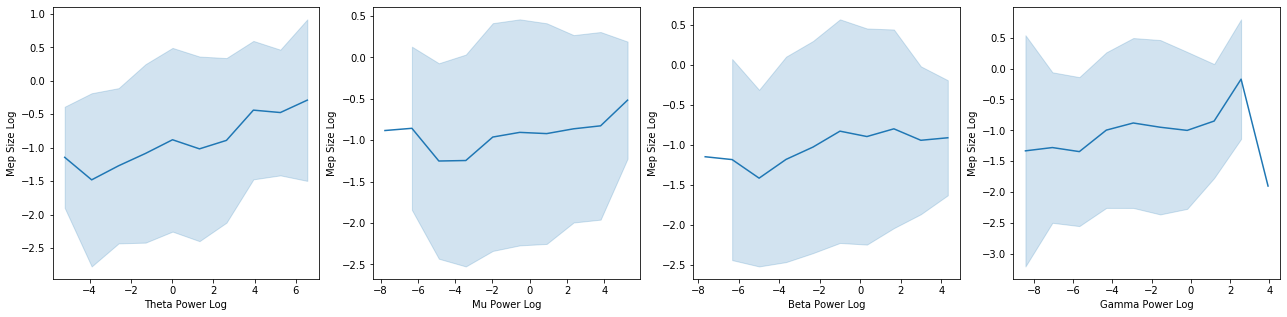

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

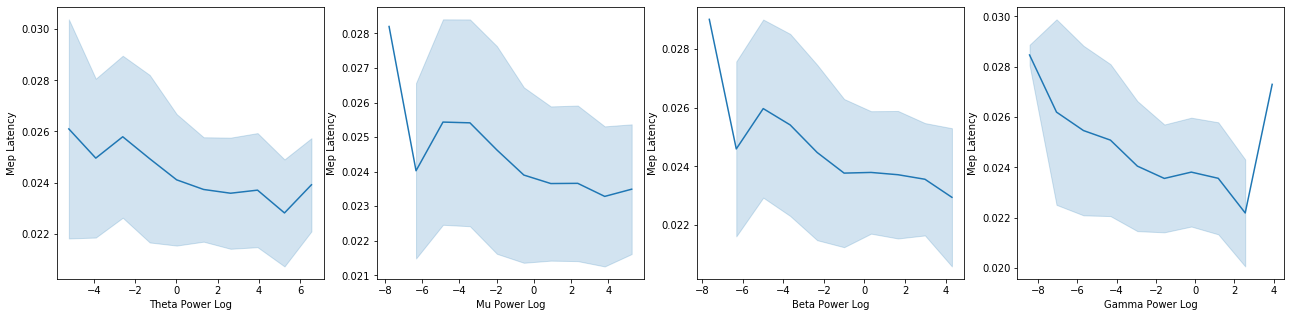

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

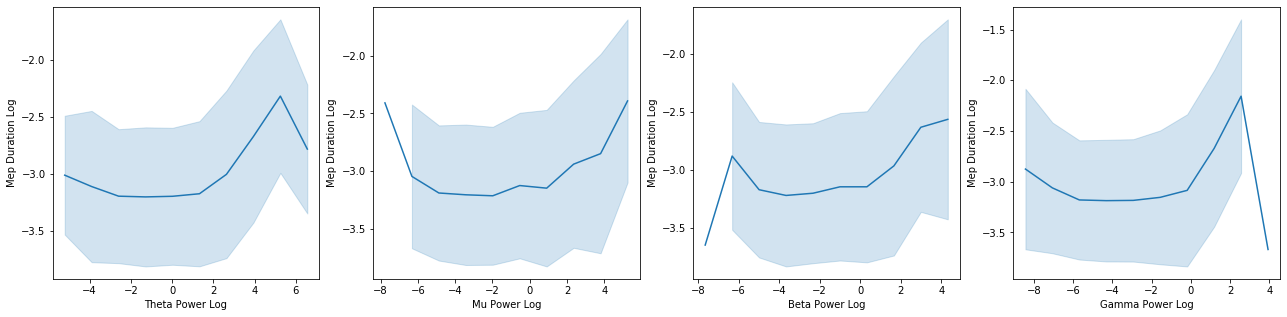

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

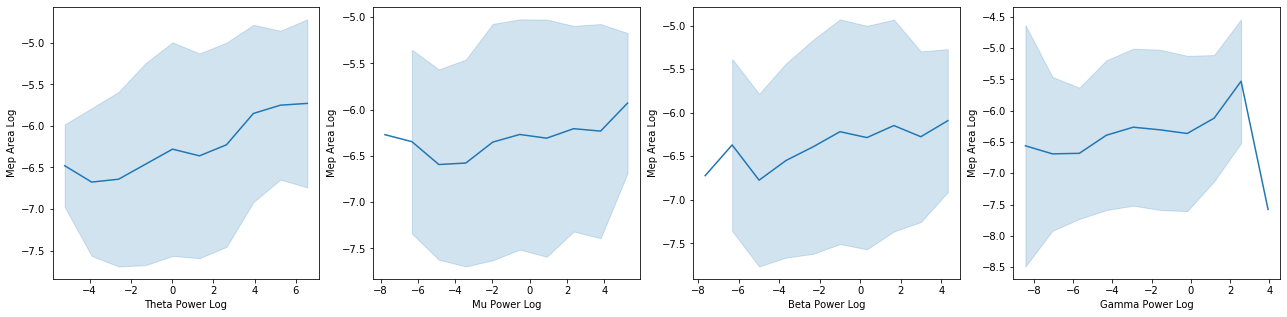

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [157]:
def plot_line(x, y, ax):
    plt.figure()
#     for sub in df['sub'].unique()[0:1]:
#         df2 = df[df['sub'] == sub]
    df2 = df
    x_segments = 10
    bins = np.linspace(df2[x].min(), df2[x].max(), x_segments+1)
    labels = np.linspace((bins[0] + bins[1])/2, (bins[-2] + bins[-1])/2, x_segments)
    df2[x + '_bin'] = pd.cut(df2[x], bins=bins, labels=labels)
    sns.lineplot(x=x + "_bin", y=y, data=df2, ci='sd', ax=ax)
    xlabel = ' '.join(x.split('_')).title()
    ylabel = ' '.join(y.split('_')).title()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_response_line(response):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5))
    plot_line('theta_power_log', response, ax=ax1)
    plot_line('mu_power_log', response, ax=ax2)
    plot_line('beta_power_log', response, ax=ax3)
    plot_line('gamma_power_log', response, ax=ax4)

plot_response_line('mep_size_log')
plot_response_line('mep_latency')
plot_response_line('mep_duration_log')
plot_response_line('mep_area_log')